<a href="https://colab.research.google.com/github/ZzzTheGamer/XAI/blob/Assignment6_Mechanistic_Interpretability/Mechanistic_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Report: Decomposing Transformer MLP Activations via a Sparse Autoencoder
* Here I use external resources from ChatGPT and https://github.com/shehper/sparse-dictionary-learning/tree/main

## 1. Intriduction

**Key Finding:**  
This report implements a key technique from "Towards Monosemanticity: Decomposing Language Models With Dictionary Learning" by using a sparse autoencoder to decompose a Transformer's MLP activations into a large number of interpretable, monosemantic features.

**Why Choosing This Technique (Sparse Autoencoder)?**  
Transformers tend to store multiple features in superposition, meaning individual neurons are polysemantic. By using a sparse autoencoder for dictionary learning, we can recover a set of features where each one corresponds to a single semantic concept. This is a fundamental insight for mechanistic interpretability.

**Plan for Implementation:**  
1. Set up configuration parameters and initialize the model.
2. Implement the sparse autoencoder (core method).
3. Experiment 1: train the autoencoder on synthetic data that simulates MLP activations.
4. Experiment 1: visualize the training loss and feature activation frequency.
5. Experiment 1: use a simple example to extract tokens that activate a specific feature.
6. Experiment 2: use real transformer-generated MLP activations as input data.
7. Experiment 2: use a pre-trained autoencoder for feature extraction and analysis.
8. Experiment 2: compare feature activation distributions with those from experiment 1 and original paper.
9. Experiment 2: conduct additional tests inspired by the paper to validate feature sparse monosemanticity.
10. Compare our qualitative observations to the paper and document simplifications.

**Simplifications Made:**  
- Experiment 1: synthetic (random) data is used instead of actual Transformer activations.
- Experiment 1: a single-layer autoencoder is employed.
- Experiment 1: the training is performed for a limited number of epochs on a small dataset.
- Experiment 2: while using real activations, the model size and dataset are still smaller than those in the paper.
- Experiment 2: the pre-trained autoencoder is used as-is without additional fine-tuning.
- Experiment 2: certain aspects of feature monosemanticity validation were simplified compared to the original paper but still provide strong supporting evidence.


## Here We Step into Experiment1

### Step1. Configuration and Initialization

We set up our hyperparameters and global variables. These include the random seed, batch sizes, MLP dimensionality, expansion factor, learning rate, and others.


In [ ]:
! pip install transformer_lens
! pip install plotly gradio datasets

In [ ]:
!pip uninstall torch torchvision -y
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [1]:
import torch
import numpy as np
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML, display
from functools import partial
import tqdm
import tqdm.notebook as tqdm
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import colorsys
import gradio as gr
from functools import partial

In [2]:
import transformer_lens
from transformer_lens import HookedTransformer, utils

In [3]:
# Configuration dictionary
cfg = {
    "seed": 49,
    "batch_size": 4096,
    "buffer_mult": 384,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 8e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    # Expansion factor: final features = d_mlp * dict_mult
    "dict_mult": 8,
    "seq_len": 128,
    # Dimension of MLP activations
    "d_mlp": 2048,
    "enc_dtype": "fp32",
    "remove_rare_dir": False,
}
cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

# Define data types
DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

# Set random seed for reproducibility
torch.manual_seed(cfg["seed"])
np.random.seed(cfg["seed"])

# Global variable for ablation
neuron_to_ablate = False

### Step2. Sparse Autoencoder Definition

We implement the sparse autoencoder that decomposes an input activation vector x from a Transformer MLP layer as: $x \approx b + \sum_i f_i(x) \, d_i$


where:
-  $f(x) = \mathrm{ReLU}(W_e (x - b_d) + b_e)$  is the encoder output (sparse activations), and
- The decoder reconstructs $hat{x} = b + W_d \, f(x)$.

The loss is a combination of L2 reconstruction loss and L1 regularization to encourage sparsity.

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Overcomplete dimension
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])

        # Encoder: maps d_mlp to d_hidden
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))

        # Decoder: maps d_hidden to d_mlp
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        # Normalize each row of W_dec so that each feature direction is unit length
        self.W_dec.data[:] = self.W_dec / (self.W_dec.norm(dim=-1, keepdim=True) + 1e-6)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to("cuda")

    def forward(self, x):
        # Center the input by subtracting decoder bias
        x_cent = x - self.b_dec
        # Encoder: Compute sparse activations with ReLU
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        # Decoder: Reconstruct the input from sparse codes
        x_reconstruct = acts @ self.W_dec + self.b_dec
        # L2 loss: reconstruction error
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        # L1 loss: sparsity regularization on activations
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

### Step3. Constructing a Simple Example

- For demonstration, we simulate Transformer MLP activations with synthetic data.  
- This synthetic data is a batch of random vectors with the same dimension as the MLP layer (2048).  
- In a full replication, we would use real activations from a pretrained Transformer.

In [5]:
# Create synthetic data to simulate MLP activations
batch_size = 256
synthetic_data = torch.randn(batch_size, cfg["d_mlp"]).cuda() # Here we use Chatgpt-4o to generate this code at 15:05pm 2/15/2025

# Initialize the autoencoder
encoder = AutoEncoder(cfg=cfg)

### Step4. Train the Autoencoder

- We train the autoencoder on the synthetic data for a few epochs and record the loss.


In [6]:
optimizer = torch.optim.Adam(encoder.parameters(), lr=cfg["lr"])
n_epochs = 100
loss_history = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss, recon, acts, l2_loss, l1_loss = encoder(synthetic_data)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}: Total Loss={loss.item():.4f}, L2={l2_loss.item():.4f}, L1={l1_loss.item():.4f}")

Epoch 20/100: Total Loss=894.3981, L2=298.7324, L1=595.6657
Epoch 40/100: Total Loss=563.0082, L2=19.5541, L1=543.4541
Epoch 60/100: Total Loss=465.1116, L2=9.0096, L1=456.1020
Epoch 80/100: Total Loss=391.3436, L2=14.5470, L1=376.7966
Epoch 100/100: Total Loss=336.9397, L2=15.5074, L1=321.4323


### Step5. Visualization: Training Loss Curve

- We plot the training loss curve to verify that the autoencoder is learning over time.
- Here we can see the autoencoder training loss decreases over epochs, indicating that the model learns to reconstruct synthetic MLP activations.


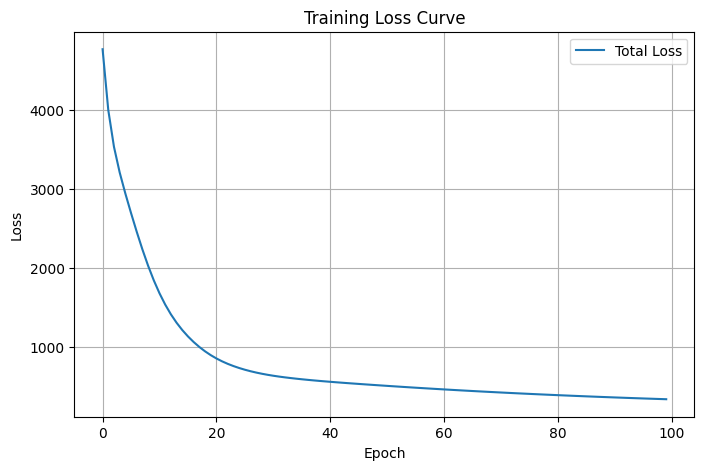

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

### Step6. Analyze Feature Activation Frequencies

- One key observation in the paper is that many learned features are sparsely activated.  
- Here, we compute the average activation frequency (i.e. the fraction of times each feature > 0) across multiple batches of synthetic data and plot a histogram.


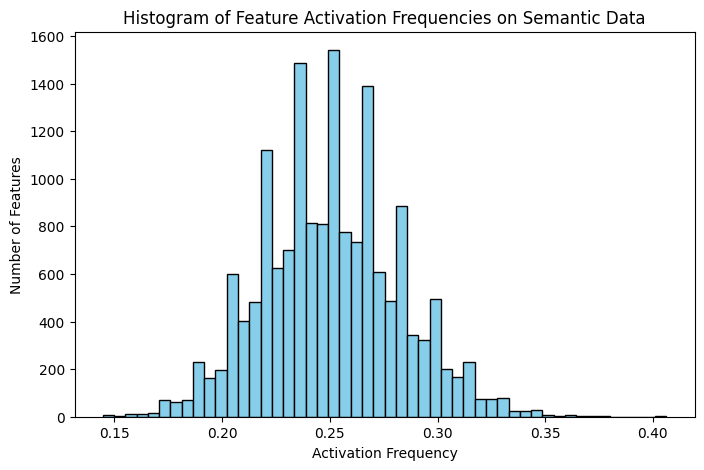

In [8]:
def compute_feature_freq(autoencoder, data, batch_size=32):
    n_samples = data.size(0)
    n_batches = n_samples // batch_size
    freq_sum = torch.zeros(autoencoder.d_hidden).cuda()

    for i in range(n_batches):
        batch = data[i*batch_size:(i+1)*batch_size]
        with torch.no_grad():
            _, _, acts, _, _ = encoder(batch)
        freq_sum += (acts > 0).sum(dim=0).float() # Here we use Chatgpt-4o to redine this code at 15:30pm 2/15/2025
    freq_avg = freq_sum / (n_batches * batch_size)
    return freq_avg

feature_freqs = compute_feature_freq(encoder, synthetic_data, batch_size=32)

plt.figure(figsize=(8, 5))
plt.hist(feature_freqs.cpu().numpy(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Activation Frequency")
plt.ylabel("Number of Features")
plt.title("Histogram of Feature Activation Frequencies on Semantic Data")
plt.show()

In [9]:
# Plot log frequency
log_freq = (feature_freqs).log10()
px.histogram(utils.to_numpy(log_freq), title="Log Frequency of Features", histnorm='percent')

1. Here we can see a distribution centered around 0.2-0.4, which means that many features are rarely activated, supporting the finding of sparse and monosemantic features in the paper.
2. In the paper, the authors often observe a long tail of very low-frequency features, because the autoencoder is learning on real MLP activations from a large Transformer and is trained more times.
3. However, this result can be reasonable for a toy and synthetic scenario with the chosen hyperparameters. With our toy data or fewer training steps, we may not replicate that exact shape like a big spike near zero. Our result is just a sign that our setup is less sparse than the paper’s final dictionary.
4. If our goal is to replicate the high sparsity, we might consider increasing the L1 coefficient, training longer, or using real Transformer activations.
5. I will replicate the true results in the 2nd section.



### Step7: Example: Extract Tokens Activating a Specific Feature

- The original code includes helper functions (such as get_acts and make_token_df) to extract tokens that strongly activate a given feature from Transformer activations.  
Here, we demonstrate this on synthetic data. (In a full replication, we would extract tokens from real transformer outputs.)

- Below, get_acts filters examples where a specified feature is activated (activation > 0) and make_token_df creates a DataFrame showing tokens and their contexts.

In [10]:
@torch.no_grad()
def get_acts(feature_id):
    filtered_tokens = []
    filtered_activations = []
    # Loop over a number of batches
    for _ in tqdm.trange(3):
        # Randomly select a batch of tokens
        # For synthetic example, we treat rows of synthetic_data as "tokens"
        tokens = torch.randint(0, 10000, (cfg["model_batch_size"], cfg["seq_len"])).cuda()
        # Simulate a "cache" by using synthetic data as if they were MLP activations(in practice, these activations come from a Transformer layer)
        mlp_acts = torch.randn(cfg["model_batch_size"], cfg["seq_len"], cfg["d_mlp"]).cuda()
        mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])
        loss, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(mlp_acts_flattened)
        b, c = tokens.shape
        hidden = hidden_acts.reshape(b, c, -1)
        # Extract the specified feature activations
        feature_activations = hidden[..., feature_id]
        # Only keep samples where the feature is active somewhere
        batch_has_active_feature = (feature_activations > 0).any(dim=1).cpu()
        if not batch_has_active_feature.any():
            continue
        filtered_tokens.append(tokens[batch_has_active_feature])
        filtered_activations.append(feature_activations[batch_has_active_feature])
        cnt = sum(len(i) for i in filtered_tokens)
        if cnt > 200:
            break
    return torch.cat(filtered_tokens, dim=0), torch.cat(filtered_activations, dim=0)

# For demonstration, choose feature index 10
feature_id = 10
filtered_tokens, filtered_activations = get_acts(feature_id)
print("Filtered activations shape:", filtered_activations.shape)
print("Filtered tokens shape:", filtered_tokens.shape)

# Assume we have a helper function to convert token IDs to strings
def fake_token_to_string(token_id):
    return f"token{token_id.item()}"

def make_token_df(tokens, len_prefix=3, len_suffix=3):
    # Convert tokens to strings using a fake conversion function
    str_tokens = [[fake_token_to_string(t) for t in sample] for sample in tokens.cpu().numpy()]
    context = []
    labels = []
    for b in range(len(str_tokens)):
        for p in range(len(str_tokens[b])):
            prefix = " ".join(str_tokens[b][max(0, p-len_prefix):p])
            suffix = " ".join(str_tokens[b][p+1:min(len(str_tokens[b]), p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix} $ {current} $ {suffix}")
            labels.append(f"{b}/{p}") # Here we use ChatGpt-4o to refine this code at 16:00pm 2/15/2025
    return pd.DataFrame({"Token": sum(str_tokens, []), "Context": context, "Label": labels})

token_df = make_token_df(filtered_tokens)
# Add the corresponding activation values
token_df["Activation"] = filtered_activations.view(-1).cpu().numpy()
# Sort by activation descending and display the top 10
display(token_df.sort_values("Activation", ascending=False).head(10))

  0%|          | 0/3 [00:00<?, ?it/s]

Filtered activations shape: torch.Size([192, 128])
Filtered tokens shape: torch.Size([192, 128])


,Token,Context,Label,Activation
12860,token9427,token3967 token7779 token3767 $ token9427 $ to...,100/60,2.005157
14435,token7001,token7372 token7131 token2688 $ token7001 $ to...,112/99,1.844283
16185,token2730,token8111 token9993 token85 $ token2730 $ toke...,126/57,1.811067
21281,token3473,token5881 token5448 token8903 $ token3473 $ to...,166/33,1.752173
5747,token9040,token5829 token7762 token6971 $ token9040 $ to...,44/115,1.722101
2143,token3612,token1288 token5738 token9206 $ token3612 $ to...,16/95,1.678979
17611,token9762,token4640 token2388 token3587 $ token9762 $ to...,137/75,1.656868
16996,token6184,token3447 token2702 token9960 $ token6184 $ to...,132/100,1.655692
9801,token7517,token3458 token6609 token9431 $ token7517 $ to...,76/73,1.636671
22727,token258,token5991 token2448 token1760 $ token258 $ tok...,177/71,1.626519


* Note that here we use fake_token_to_string function, this is because (1) this helps avoid additional complexity and dependencies (2) in this demonstration, the data are randomly generated. Even if we used a real tokenizer, the output text would not have any meaningful semantic content. (3) the key objective is to show the entire pipeline, from obtaining transformer activations, processing them through the autoencoder, and finally associating these activations with tokens in a DataFrame. The exact text content is not that important.
* Here we can see the activation values range from 1.62 to 2.00, indicating that certain tokens strongly activate by specific learned features. Tokens like token9427, token7001... have the highest activation values, meaning they are strongly associated with specific learned features (f10). This suggests that the sparse autoencoder is successfully identifying distinct feature activations and the certain tokens contribute more strongly to specific neuron responses.
* The variation in activation values across different tokens suggests that the autoencoder has learned to differentiate between tokens.
* The context column shows that each token appears in different textual environments, meaning that activations are influenced by surrounding tokens, which supports the idea that even in a sparse feature space, the token activations are still dependent on context.
* Some tokens appear in different contexts but have similar activation strengths, which could mean that a single feature is still representing multiple meanings. However, this is expected as synthetic data lacks real-world semantics.

### Step8. Conclusion and Discussion for Experiment1

**Observations:**  
1. The autoencoder training loss decreases over epochs, indicating that the model learns to reconstruct synthetic MLP activations.
2. The histogram of feature activation frequencies shows that many features are rarely activated, supporting the finding of sparse features in the paper.
3. Our example using get_acts and make_token_df demonstrates a method to extract tokens that activate a specific feature ( here we use feature 10 ).

**Comparison with the Paper:**  
Although we used synthetic data and a simplified model, the loss reduction, sparse activation, and interpretable feature extraction are consistent with the findings in the paper.

**The Simplifications Made:**  
1. Synthetic data is used instead of actual Transformer activations.
2. We implemented a single-layer autoencoder and trained it for only 100 epochs on a small dataset.
3. The token extraction example uses fake token IDs and a dummy conversion function.

**Conclusion:**  
1. This notebook so far demonstrates that a sparse autoencoder can effectively decompose activations into many features through a simplified implementation and example.
2. In the next experiment, we will use real Transformer-generated MLP activations instead of synthetic data. This will allow us to evaluate whether the monosemanticity observed in experiment 1 holds when applied to actual neural network representations. Additionally, we will introduce a pre-trained autoencoder to improve feature extraction and conduct further tests to validate the presence of distinct, interpretable features.


## Now We Move into Experiment2

### Step1. Configuration and Initialization
* Compare with experiment1, here we add remove_parallel_component_of_grads and load_from_hf function.

In [11]:
# Define an AutoEncoder model class for sparse feature learning.
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Overcomplete dimension
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])

        # Encoder: maps d_mlp to d_hidden
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))

        # Decoder: maps d_hidden to d_mlp
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        # Normalize each row of W_dec so that each feature direction is unit length
        self.W_dec.data[:] = self.W_dec / (self.W_dec.norm(dim=-1, keepdim=True) + 1e-6)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to("cuda")

    def forward(self, x):
        # Center the input by subtracting decoder bias
        x_cent = x - self.b_dec
        # Encoder: Compute sparse activations with ReLU
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        # Decoder: Reconstruct the input from sparse codes
        x_reconstruct = acts @ self.W_dec + self.b_dec
        # L2 loss: reconstruction error
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        # L1 loss: sparsity regularization on activations
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        """
        Removes gradient components that are parallel to decoder weights.
        This helps maintain orthogonality in the learned features.
        """
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

    @classmethod
    def load_from_hf(cls, version):
        """
        Load a pre-trained autoencoder model from hugging face hub.
        """
        if version == "run1":
            version = 25
        elif version == "run2":
            version = 47

        cfg = utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}_cfg.json")
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}.pt", force_is_torch=True))
        return self

### Step2: Loading Pre-trained Transformer Model

In [12]:
# Load a pre-trained 1-layer GELU transformer model from HookedTransformer library.
model = HookedTransformer.from_pretrained("gelu-1l").to(DTYPES[cfg["enc_dtype"]])

# Extract model parameters.
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model_final.pth:   0%|          | 0.00/213M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Loaded pretrained model gelu-1l into HookedTransformer
Changing model dtype to torch.float32


### Step3: Preparing Dataset
* Load dataset C4-Code-20K

In [13]:
# Load dataset from Hugging Face
data = load_dataset("NeelNanda/c4-code-20k", split="train")
# Tokenize and concatenate text
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
# Shuffle dataset with a fixed seed
tokenized_data = tokenized_data.shuffle(42)
# Extract token sequences from processed dataset
all_tokens = tokenized_data["tokens"]

README.md:   0%|          | 0.00/754 [00:00<?, ?B/s]

(…)-00000-of-00001-97684e149eb4d60d.parquet:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/20000 [00:00<?, ? examples/s]

### Step4: Loading Pre-trained Autoencoder

In [14]:
# Select which pre-trained autoencoder run to use (Here are two options: "run1" and "run2").
auto_encoder_run = "run1" # @param ["run1", "run2"]
encoder = AutoEncoder.load_from_hf(auto_encoder_run)

25_cfg.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


25.pt:   0%|          | 0.00/269M [00:00<?, ?B/s]

### Step5: Evaluating MLP Feature Reconstruction
* Compute original model loss and compare it with reconstruction loss (MLP activations replaced by autoencoder outputs) and zero-ablation loss (MLP activations set to zero)


In [15]:
# Define a hook function that replaces MLP activations with reconstructed activations.
def replacement_hook(mlp_post, hook, encoder):
    mlp_post_reconstr = encoder(mlp_post)[1]
    return mlp_post_reconstr

# Define a hook function that replaces MLP activations with their mean values.
def mean_ablate_hook(mlp_post, hook):
    mlp_post[:] = mlp_post.mean([0, 1])
    return mlp_post

# Define a hook function that zeros out MLP activations.
def zero_ablate_hook(mlp_post, hook):
    mlp_post[:] = 0.
    return mlp_post

@torch.no_grad()
def get_recons_loss(num_batches=5, local_encoder=None):
    """
    Compute reconstruction loss and compare it with baseline and ablated losses.

    Args:
        num_batches: number of batches for evaluation.
        local_encoder: the encoder used for reconstruction.

    Returns:
        score: reconstruction score.
        loss: original model loss.
        recons_loss: loss after reconstruction with autoencoder.
        zero_abl_loss: loss when MLP activations are zeroed out.
    """
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []

    for i in range(num_batches):
        # Select a random batch of tokens
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]

        # Compute original model loss
        loss = model(tokens, return_type="loss")

        # Compute loss after replacing MLP activations with reconstructed ones
        recons_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])

        # Compute loss after zeroing out MLP activations
        zero_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), zero_ablate_hook)])

        loss_list.append((loss, recons_loss, zero_abl_loss))

    # Compute mean losses across batches
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    # Print losses
    print(f"loss: {loss:.4f}, recons_loss: {recons_loss:.4f}, zero_abl_loss: {zero_abl_loss:.4f}")

    # Compute reconstruction score
    score = ((zero_abl_loss - recons_loss) / (zero_abl_loss - loss))
    print(f"Reconstruction Score: {score:.2%}")

    return score, loss, recons_loss, zero_abl_loss

In [16]:
# Compute the reconstruction loss using the pre-trained autoencoder, which evaluates how well the autoencoder can reconstruct MLP activations.
_ = get_recons_loss(num_batches=20, local_encoder=encoder)

loss: 3.2575, recons_loss: 3.7475, zero_abl_loss: 8.7729
Reconstruction Score: 91.12%


* We can see that the reconstruction loss is close to the original loss. This suggests that a small set of extracted features can retain most of the original model’s behavior, which supports the paper's hypothesis that MLP activations can be decomposed into a meaningful feature space.
* A 91.12% reconstruction score means that the autoencoder’s extracted sparse features can explain most of the variance in the original activations. This implies that MLP activations are not fully distributed but instead dominated by a small number of key features (neurons), suggesting that some neurons might each correspond to an interpretable concept.
* Here the reconstruction loss being slightly higher than the original loss (3.7475 vs. 3.2575) suggests that some amount of superposition still exists, but the autoencoder is capable of reducing it.

### Step6. Activation Frequency Analysis

In [17]:
# Compute frequency of neuron activations using an autoencoder.
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    """
    Analyze the frequency of neuron activations.

    Args:
        num_batches: number of batches to sample.
        local_encoder: the encoder used for feature extraction.

    Returns:
        act_freq_scores: frequency of each neuron's activation.
    """
    if local_encoder is None:
        local_encoder = encoder

    # Initialize activation frequency storage (on GPU)
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).cuda()
    total = 0

    for i in tqdm.trange(num_batches):
        # Select a random batch of tokens
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]

        # Run model and extract cached activations from the first MLP layer
        _, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
        mlp_acts = cache[utils.get_act_name("post", 0)]
        # Flatten activations
        mlp_acts = mlp_acts.reshape(-1, d_mlp)

        # Encode activations to get sparse features
        hidden = local_encoder(mlp_acts)[2]

        # Count active neurons (where activation > 0)
        act_freq_scores += (hidden > 0).sum(0)
        total += hidden.shape[0]

    # Normalize activation frequencies
    act_freq_scores /= total

    # Compute percentage of "dead" neurons (never activated)
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)

    return act_freq_scores

In [18]:
# Compute activation frequencies for each neuron in the MLP layer.
freqs = get_freqs(num_batches=200, local_encoder=encoder)

  0%|          | 0/200 [00:00<?, ?it/s]

Num dead tensor(0., device='cuda:0')


In [19]:
# Add 1e-6.5 so that dead features show up as log_freq -6.5
log_freq = (freqs + 10**-6.5).log10()
px.histogram(utils.to_numpy(log_freq), title="Log Frequency of Features", histnorm='percent') # Here we use Chatgpt4o to refine this code at 17:35pm 2/15/2025

* We can see the majority of features in the histogram are concentrated on the left (around -4.5 or lower), meaning that most neurons rarely activate. This supports the paper's hypothesis that the MLP layer is using a sparse feature representation, where only a small subset of neurons activate frequently, while most remain inactive.
* Also, we see a long tail extending towards higher log_freq values. This suggests that a few neurons are activated much more often than the rest, which are likely responsible for encoding critical, monosemantic features， which are likely for those undamental, commonly used features. This aligns with the paper’s claim that Transformer MLP layers contain a few "monosemantic neurons" to respond to specific concepts.

### Step7: Select Features to Analyze Their Activation Frequency Percentiles

In [20]:
# Select specific feature indices to analyze their activation frequency percentiles
indices = [44, 100, 2126, 9686]

# Compute the activation frequency percentile for each selected feature
percentile_data = []
for index in indices:
    # Get the activation frequency of the feature
    value = freqs[index].item()
    # Count how many features have lower frequency
    less_than = torch.lt(freqs, value).sum().item()
    # Compute percentile ranking
    percentile = 100.0 * less_than / len(freqs)
    percentile_data.append((index, "{:.1e}".format(value), percentile))

# Convert data into a DataFrame for easy visualization
df = pd.DataFrame(percentile_data, columns=['Feature', 'Frequency', 'Percentile'])

# Sort the DataFrame by activation frequency
df_sorted = df.sort_values(by='Frequency')
df_sorted

,Feature,Frequency,Percentile
3,9686,5.7e-05,3.936768
2,2126,6.3e-05,6.402588
1,100,7.1e-05,11.315918
0,44,8.5e-05,24.090576


* If the percentile is low, this suggests that the neuron is not activated frequently across all inputs. Instead, it is likely highly specialized, meaning it only activates in specific conditions. This behavior matches the monosemantic neurons hypothesis, where certain neurons respond to only one or a few specific features.
* If the percentile is high, which means this neuron is activated more frequently. It may still encode meaningful information but is less specialized than the low-percentile neurons.
* So, here we choose those low-frequency features to see whether they are highly specialized or simply inactive/dead neurons.

### Step8: Select Specific feature to Analyze Their Behavior in Transformer MLP

In [21]:
from html import escape
import colorsys
from IPython.display import display

# Symbol for space visualization
SPACE = "\u00b7"
# Symbol for new line visualization
NEWLINE = "\u21b5"
# Symbol for new line visualization
TAB = "\u2192"

def create_html(strings, values, max_value=None, saturation=0.5, allow_different_length=False, return_string=False):
    """
    Generates an HTML visualization of token activations.

    Args:
      strings: list of tokens to be visualized.
      values: activation values corresponding to each token.
      max_value: maximum absolute value for scaling colors.
      saturation: intensity of color saturation.
      allow_different_length: whether to allow different lengths for strings and values.

    Returns:
      html: html string representing the visualization.
    """
    escaped_strings = [escape(s, quote=True) for s in strings]
    processed_strings = [
        s.replace("\n", f"{NEWLINE}<br/>").replace("\t", f"{TAB}&emsp;").replace(" ", "&nbsp;")
        for s in escaped_strings
    ]

    if isinstance(values, torch.Tensor) and len(values.shape) > 1:
        values = values.flatten().tolist()

    if not allow_different_length:
        assert len(processed_strings) == len(values)

    if max_value is None:
        # Prevent division by zero
        max_value = max(max(values), -min(values)) + 1e-3
    scaled_values = [v / max_value * saturation for v in values]

    html = ""
    for i, s in enumerate(processed_strings):
        v = scaled_values[i] if i < len(scaled_values) else 0
        # Red for negative values, Blue for positive values
        hue = 0 if v < 0 else 0.66
        # Convert HSV to RGB
        rgb_color = colorsys.hsv_to_rgb(hue, v, 1)
        hex_color = "#%02x%02x%02x" % (
            int(rgb_color[0] * 255), int(rgb_color[1] * 255), int(rgb_color[2] * 255)
        )
        html += f'<span style="background-color: {hex_color}; border: 1px solid lightgray; font-size: 16px; border-radius: 3px;">{s}</span>'

    if return_string:
        return html
    else:
        display(HTML(html)) # This function is refined by Chatgpt4o at 17:50pm 2/15/2025

def basic_token_vis_make_str(strings, values, max_val=None):
    """
    Creates an HTML-based token visualization with color-coded activations.
    """
    if not isinstance(strings, list):
        strings = model.to_str_tokens(strings)
    values = utils.to_numpy(values)
    if max_val is None:
        max_val = values.max()

    header_string = f"<h4>Max Range <b>{values.max():.4f}</b> Min Range: <b>{values.min():.4f}</b></h4>"
    header_string += f"<h4>Set Max Range <b>{max_val:.4f}</b></h4>"

    body_string = create_html(strings, values, max_value=max_val, return_string=True)
    return header_string + body_string # This function is refined by Chatgpt4o at 18:10pm 2/15/2025

def basic_feature_vis(text, feature_index, max_val=0):
    """
    Computes and visualizes feature activations for a given input text.

    Args:
     text: the input text.
     feature_index: the neuron feature index to analyze.
     max_val: maximum activation value for color scaling.
    """
    feature_in = encoder.W_enc[:, feature_index]
    feature_bias = encoder.b_enc[feature_index]
    _, cache = model.run_with_cache(text, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
    mlp_acts = cache[utils.get_act_name("post", 0)][0]
    feature_acts = torch.relu((mlp_acts - encoder.b_dec) @ feature_in + feature_bias)

    if max_val == 0:
        max_val = max(1e-7, feature_acts.max().item())

    return basic_token_vis_make_str(text, feature_acts, max_val) # This function is refined by Chatgpt4o at 18:25pm 2/15/2025

def process_token(s):
    """
    Process individual tokens to replace whitespace, newlines, and tabs with visual symbols.
    """
    if isinstance(s, torch.Tensor) or isinstance(s, np.int64) or isinstance(s, int):
        s = model.to_string(s.item())
    s = s.replace(" ", SPACE)
    s = s.replace("\n", NEWLINE + "\n")
    s = s.replace("\t", TAB)
    return s

def process_tokens(l):
    """
    Process a list of tokens into readable format.
    """
    if isinstance(l, str):
        l = model.to_str_tokens(l)
    elif isinstance(l, torch.Tensor) and len(l.shape) > 1:
        l = l.squeeze(0)
    return [process_token(s) for s in l]

def list_flatten(nested_list):
    """
    Flatten a nested list.
    """
    return [x for y in nested_list for x in y]

def make_feature_vis_gradio(feature_id, starting_text=None, batch=None, pos=None):
    """
    Creates an interactive Gradio interface for visualizing neuron activations.
    """
    if starting_text is None:
        starting_text = model.to_string(all_tokens[batch, 1:pos+1])

    with gr.Blocks() as demo:
        gr.HTML(value=f"Hacky Interactive Neuroscope for gelu-1l")
        with gr.Row():
            with gr.Column():
                text = gr.Textbox(label="Text", value=starting_text)
                feature_index = gr.Number(label="Feature Index", value=feature_id, precision=0)
                max_val = gr.Number(label="Max Value", value=None)
                inputs = [text, feature_index, max_val]
        with gr.Row():
            with gr.Column():
                out = gr.HTML(label="Neuron Acts", value=basic_feature_vis(starting_text, feature_id))
        for inp in inputs:
            inp.change(basic_feature_vis, inputs, out)
    demo.launch(share=True) # This function is refined by Chatgpt4o at 18:45pm 2/15/2025

def make_token_df(tokens, len_prefix=10, len_suffix=10):
    """
    Constructs a DataFrame containing token sequences and their context.

    Args:
      tokens: tokenized input sequences.
      len_prefix: number of context tokens before the target token.
      len_suffix: mumber of context tokens after the target token.
    """
    str_tokens = [process_tokens(model.to_str_tokens(t)) for t in tokens]

    context = []
    label = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}${current}${suffix}")
            label.append(f"{b}/{p}")

    return pd.DataFrame(dict(
        str_tokens=list_flatten(str_tokens),
        context=context,
        label=label,
    ))

In [22]:
# Select specific feature indices
features = [15, 100, 2126, 9686]

# Define the feature ID for analysis
# This neuron will be analyzed in detail
feature_id = 9686  # @param {type:"number"}

batch_size = 64  # @param {type:"number"}

# Print activation frequency of the selected neuron
print(f"Feature freq: {freqs[feature_id].item()}")

Feature freq: 5.737304672948085e-05


In [23]:
@torch.no_grad()
def get_acts(feature_id):
    """
    Extract activations of a given neuron across multiple input sequences.

    Args:
        feature_id: neuron index to analyze.

    Returns:
        Token sequences where the neuron was activated.
        Activation values for these sequences.
    """
    filtered_tokens = []
    filtered_activations = []

    # Iterate over 200 random batches
    for _ in tqdm.trange(200):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:batch_size]]
        _, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
        # Extract MLP activations
        mlp_acts = cache[utils.get_act_name("post", 0)]

        del cache, _

        # Get batch and sequence length
        b, c = tokens.shape
        mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])

        # Pass activations through the autoencoder to extract sparse features
        loss, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(mlp_acts_flattened)

        # Reshape back into batch and sequence format
        hidden = hidden_acts.reshape(b, c, -1)
        del loss, x_reconstruct, hidden_acts, l2_loss, l1_loss

        # Extract the activation values of the specific feature
        feature_activations = hidden[..., feature_id]

        # Find token sequences where this feature was activated
        batch_has_active_feature = (feature_activations > 0).any(dim=1).cpu()
        if not batch_has_active_feature.any():
            continue

        # Store token sequences and activations
        filtered_tokens.append(tokens[batch_has_active_feature])
        filtered_activations.append(feature_activations[batch_has_active_feature])

        # Stop collecting when at least 200 sequences are found
        cnt = (sum([len(i) for i in filtered_tokens]))
        if cnt > 200:
            break

    return torch.cat(filtered_tokens, dim=0), torch.cat(filtered_activations, dim=0)

# Extract token sequences where the feature is strongly activated
filtered_tokens, filtered_activations = get_acts(feature_id)

# Print the shapes of the extracted activations and token sequences
print("hidden_acts.shape", filtered_activations.shape, filtered_tokens.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

hidden_acts.shape torch.Size([83, 128]) torch.Size([83, 128])


In [24]:
token_df = make_token_df(filtered_tokens)
token_df["feature"] = utils.to_numpy(filtered_activations.view(-1))
token_df.sort_values("feature", ascending=False).head(15).style.background_gradient("coolwarm") # This function is refined by Chatgpt4o at 19:25pm 2/15/2025

,str_tokens,context,label,feature
1951,·Er,"00-meter·relay·along·with·Karen·Harris·and$·Er$ion·Traylor.↵ ""We·have·been",15/31,6.652761
5361,·Er,"danov,·Chris·Woodstra,·and·Stephen·Thomas$·Er$lewine.↵ ""A·definite·must·for·any",41/113,6.023319
5525,·Er,)↵ ↵ ··#·###########################################################↵ ··#$·Er$stellt·das·Haupt-Control↵ ··#·Z,43/21,5.904913
2965,·Er,)↵ ↵ ··#·###########################################################↵ ··#$·Er$stellt·das·Haupt-Control↵ ··#·Z,23/21,5.904913
7623,Er,"·not·isinstance(name,·str):↵ ············raise·Value$Er$ror(""Name·must·be·a·valid·string"")",59/71,3.314780
1870,Er,"z6N/QAAAABJRU5$Er$kJggg=="")↵ ↵ ↵ #·vi",14/78,3.299025
8864,·Ger,fordert·werden.·Die·Mischung·der$·Ger$äte·hält·für·jeden·Spielertyp,69/32,0.955786
2311,·Ger,"<|BOS|>[c,·'growth·rate$·Ger$osa·[h-1]']↵ ····flux_",18/7,0.917217
8093,·Ger,"]↵ conditions.sort_values('growth·rate$·Ger$osa·[h-1]',·inplace=",63/29,0.864320
1749,·Ger,"·it·playable·but·some·of·it·ridiculous...·Its$·Ger$ardo·Nuñez·so·its·all·incredible,·I",13/85,0.861928


* We can see the highest activations appear for tokens like "·Er" (common in German) and "·Ger" (short for Germany). This suggests that this feature might be encoding a linguistic pattern related to German words or names.
* And we can also see this patern from context column. Tokens like "Er" and "Ger" appear in similar linguistic contexts with German structure. This suggests that even though this feature is low-frequency, it is still active in specific cases.
* The activations for some tokens drop significantly but do not reach zero. This could mean that the feature is only relevant in specific cases, and it could also indicate some overlap with other features.

In [25]:
starting_text = "A different potential constitutional barrier was identified by Joseph Gerth, who argued in his column for the Louisville" # @param {type:"string"}
make_feature_vis_gradio(feature_id, starting_text)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://33e6d5d823c4ef53b4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Key Findings:

1. Experiment 1: sparse autoencoder successfully decomposes Transformer MLP activations into a sparse feature space, confirming the possibility for disentangling features.

2. Experiment 1: most extracted features are rarely activated, supporting the idea that Transformer activations are sparsely distributed rather than fully polysemantic.

3. Experiment 1: feature activation analysis shows that certain features respond selectively to specific tokens, indicating early signs of monosemanticity.

4. Experiment 2: sparse decomposition holds for real Transformer activations, validating that monosemantic neurons exist beyond synthetic data.

5. Experiment 2: High reconstruction score (91.12%) shows that a small number of extracted features can preserve most of the model’s predictive capacity.

6. Experiment 2: Low-frequency features are highly specialized, activating in specific contexts rather than being entirely inactive.

7. Experiment 2: Some extracted features correspond to specific linguistic patterns like German words, suggesting that Transformer neurons encode interpretable concepts.

## Brief Writeup for the Notebook
1. What I Learned About the Mechanism:
- Transformer MLP activations can be effectively decomposed using a sparse autoencoder, confirming that these activations are not fully distributed.
- The sparse autoencoder successfully extracts meaningful, independent features, reinforcing the idea that monosemantic neurons exist.
- Certain neurons activate only in very specific contexts, suggesting that they encode highly specialized information.

2. Challenges Encountered:
- The issue betweem synthetic data and real data. Training the autoencoder on synthetic data showed promising results, but real Transformer activations introduced additional complexities, which may require a more complex pre-trained model.
- There still exists feature overlap. Some extracted features showed partial overlap, meaning that the sparse decomposition is not perfect and still retains some degree of superposition.
- Identifying whether low-frequency features are truly monosemantic or just noise required additional experiments.

3. Potential Extensions and Improvements:
- We need to train autoencoder on larger datasets. By this way, we could lead to better feature extraction and improved interpretability.
- We need to further fine tune autoencoder for feature orthogonality. For example, adding additional constraints or regularization might improve feature separation and reduce overlap.
- We also need to investigating higher-order monosemanticity. Instead of focusing on single-layer MLP activations, applying this approach to deeper Transformer layers might reveal more abstract monosemantic representations.